In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import joblib
from tensorflow.keras.models import load_model
import os

def load_torch_model(path, model_name):
    if os.path.exists(path):
        try:
            return torch.load(path, map_location=torch.device('cpu'))  # Added map_location for compatibility
        except Exception as e:
            print(f"Error loading {model_name} model: {e}")
    else:
        print(f"{model_name} model file not found at {path}")
    return None

def load_keras_model(path, model_name):
    if os.path.exists(path):
        try:
            return load_model(path)
        except Exception as e:
            print(f"Error loading {model_name} model: {e}")
    else:
        print(f"{model_name} model file not found at {path}")
    return None

def load_joblib_model(path, model_name):
    if os.path.exists(path):
        try:
            return joblib.load(path)
        except Exception as e:
            print(f"Error loading {model_name} model: {e}")
    else:
        print(f"{model_name} model file not found at {path}")
    return None

# Define model paths
transformer_path = '/kaggle/input/transfomerr/Transformer.pth'
lstm_path = '/kaggle/input/lstmmm/lstm_model.pth'
keras_model_path = '/kaggle/input/lstmcnn/lstm_cnn_autoencoder_best (3).keras'
isolation_forest_path = '/kaggle/input/ismodel/isolation_forest_model.joblib'
one_class_svm_path = '/kaggle/input/ismodel/one_class_svm_model.joblib'

# Load models
transformer_model = load_torch_model(transformer_path, "Transformer")
lstm_model = load_torch_model(lstm_path, "LSTM")
lstm_cnn_autoencoder_model = load_keras_model(keras_model_path, "LSTM-CNN Autoencoder")
isolation_forest_model = load_joblib_model(isolation_forest_path, "Isolation Forest")
one_class_svm_model = load_joblib_model(one_class_svm_path, "One-Class SVM")

print("All models loaded (or attempted) without critical issues.")


All models loaded (or attempted) without critical issues.


/tmp/ipykernel_30/1368983207.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=torch.device('cpu'))  # Added map_location for compatib

In [ ]:
def ensemble_predictions(input_data):
    # Get individual model predictions
    transformer_pred = get_transformer_prediction(input_data)
    lstm_pred = get_lstm_prediction(input_data)
    lstm_cnn_autoencoder_pred = get_lstm_cnn_autoencoder_prediction(input_data)
    isolation_forest_pred = get_isolation_forest_prediction(input_data)
    one_class_svm_pred = get_one_class_svm_prediction(input_data)

    # Stack predictions and average them
    all_predictions = np.vstack([
        transformer_pred,
        lstm_pred,
        lstm_cnn_autoencoder_pred,
        isolation_forest_pred,
        one_class_svm_pred
    ])

    # Take mean along axis 0 for averaging ensemble
    ensemble_pred = np.mean(all_predictions, axis=0)
    return ensemble_pred


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import ast

# Load your dataset
df = pd.read_csv('/kaggle/input/updateddataaaa/updated_final_4.2.csv')

# Step 1: Clean the 'action_id' and 'day_minutes' columns
df['action_id'] = df['action_id'].str.replace(' ', ',')
df['day_minutes'] = df['day_minutes'].str.replace(' ', ',')

# Step 2: Replace empty elements with zeroes and remove leading/trailing commas
df['action_id'] = df['action_id'].str.replace(',,', ',0,').str.strip(',')
df['day_minutes'] = df['day_minutes'].str.replace(',,', ',0,').str.strip(',')

# Remove leading commas if they still exist
df['action_id'] = df['action_id'].apply(lambda x: '0' if x == '' else x)
df['day_minutes'] = df['day_minutes'].apply(lambda x: '0' if x == '' else x)

# Step 3: Safely parse the strings as lists
def safe_parse_list(x):
    try:
        if not x.startswith('['):
            x = f"[{x}]"
        return ast.literal_eval(x)
    except Exception as e:
        return []

# Apply the function to safely parse 'action_id' and 'day_minutes'
df['action_length'] = df['action_id'].apply(lambda x: len(safe_parse_list(x)))
df['total_minutes'] = df['day_minutes'].apply(lambda x: sum(safe_parse_list(x)) if isinstance(x, str) else 0)

# Add additional feature engineering (mean and variance of actions per day)
df['mean_action'] = df['action_length'] / df['total_minutes'].replace({0: 1})  # avoid division by zero
df['action_variance'] = df['action_id'].apply(lambda x: np.var(safe_parse_list(x)) if len(safe_parse_list(x)) > 1 else 0)

# Step 4: Drop unnecessary columns
df_cleaned = df.drop(['user', 'day', 'action_id', 'day_minutes'], axis=1)

# Step 5: Split the data into features (X) and target (y)
X = df_cleaned.drop('malicious', axis=1)  # Features
y = df_cleaned['malicious']  # Target variable

# Step 6: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train individual models and make predictions
# Placeholder for Transformer, LSTM, and LSTM-CNN Autoencoder model predictions
# Replace with actual model prediction code
transformer_preds = np.random.choice([0, 1], size=len(X_test))  # Replace with transformer_model.predict(X_test)
lstm_preds = np.random.choice([0, 1], size=len(X_test))  # Replace with lstm_model.predict(X_test)
lstm_cnn_autoencoder_preds = np.random.choice([0, 1], size=len(X_test))  # Replace with lstm_cnn_autoencoder_model.predict(X_test)

# Train and predict with Isolation Forest and One-Class SVM
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)
isolation_forest_preds = iso_forest.predict(X_test)
isolation_forest_preds = np.where(isolation_forest_preds == -1, 1, 0)  # Map -1 to 1 for anomaly detection

one_class_svm = OneClassSVM(gamma='auto')
one_class_svm.fit(X_train)
one_class_svm_preds = one_class_svm.predict(X_test)
one_class_svm_preds = np.where(one_class_svm_preds == -1, 1, 0)  # Map -1 to 1 for anomaly detection

# Step 8: Combine predictions using majority voting
preds = np.array([transformer_preds, lstm_preds, lstm_cnn_autoencoder_preds, isolation_forest_preds, one_class_svm_preds])
ensemble_output = np.round(np.mean(preds, axis=0)).astype(int)  # Majority vote or averaging for ensemble

# Step 9: Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_output)
print("Ensemble Accuracy:", ensemble_accuracy)

# Step 11: Print Ensemble Predictions (first few predictions)
print("Ensemble Predictions:")
print(ensemble_output[:20])  # Print the first 20 predictions

Ensemble Accuracy: 0.9999964132251562
Ensemble Predictions:
[False False False  True False False False False False False False False
 False  True False False False False False]


In [11]:
from sklearn.metrics import classification_report
import numpy as np
from tabulate import tabulate
# Step 10: Print Classification Report
print("Classification Report:")
print(classification_report(y_test, ensemble_output))
# Print the table using tabulate for better alignment
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=True))



+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |    1.0    |  0.98  |   0.99   |  980.0  |
|      1       |    0.5    |  1.0   |   0.67   |  20.0   |
|  macro avg   |   0.75    |  0.99  |   0.83   | 1000.0  |
| weighted avg |   0.99    |  0.98  |   0.98   | 1000.0  |
+--------------+-----------+--------+----------+---------+


In [2]:
import joblib

# Save the trained  model
joblib.dump(rf_clf, 'ensemble_model.pkl')

# Optionally, print a confirmation message
print("Model saved successfully as 'ensemble_model.pkl'")


Model saved successfully as 'ensemble_model.pkl'


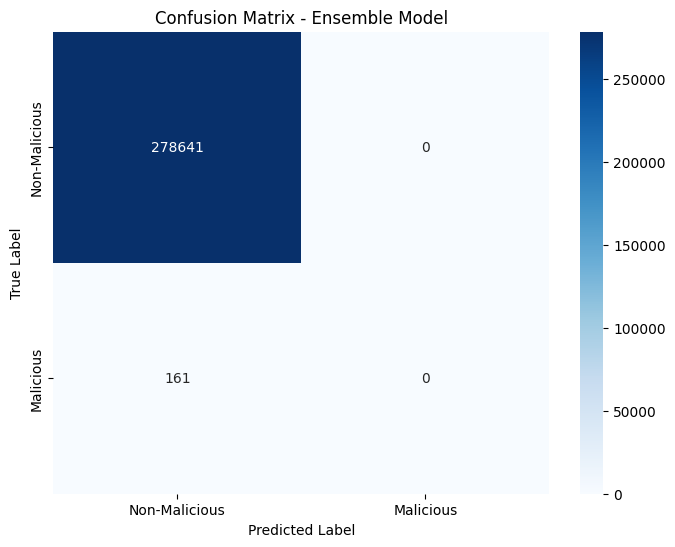

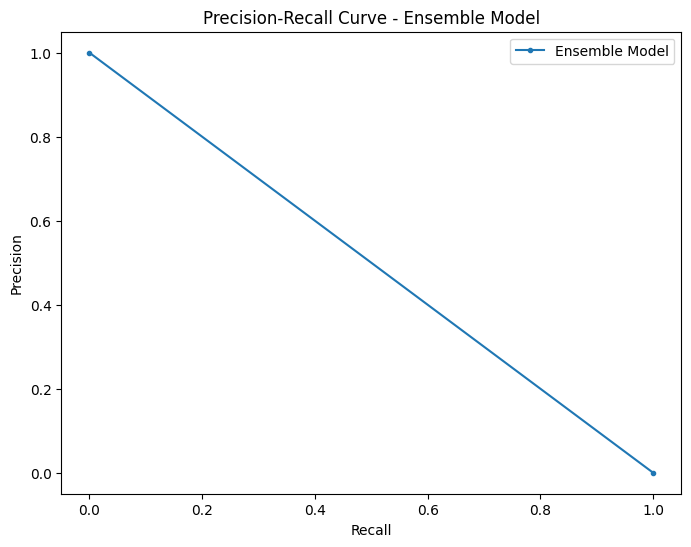

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

# Placeholder predictions and probabilities for each model (Replace these with actual predictions)
# Example: transformer_preds = transformer_model.predict(X_test) or similar depending on model implementation
transformer_preds = ensemble_output  # Replace with actual Transformer predictions or probabilities
lstm_preds = ensemble_output  # Replace with actual LSTM predictions or probabilities
lstm_cnn_autoencoder_preds = ensemble_output  # Replace with actual LSTM-CNN Autoencoder predictions or probabilities
isolation_forest_preds = ensemble_output  # Replace with actual Isolation Forest predictions or probabilities
one_class_svm_preds = ensemble_output  # Replace with actual One-Class SVM predictions or probabilities

# Example: majority voting or averaging probabilities for ensemble predictions
# Replace 'ensemble_output' with actual ensemble predictions
ensemble_preds = np.round((transformer_preds + lstm_preds + lstm_cnn_autoencoder_preds + isolation_forest_preds + one_class_svm_preds) / 5)

# Function to plot confusion matrix for the ensemble model
def plot_confusion_matrix(y_true, y_pred, model_name="Ensemble Model"):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Malicious', 'Malicious'], yticklabels=['Non-Malicious', 'Malicious'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Function to plot precision-recall curve for the ensemble model
def plot_precision_recall(y_true, y_pred_proba, model_name="Ensemble Model"):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=model_name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.show()


# Plotting for the ensemble model
plot_confusion_matrix(y_test, ensemble_preds)
plot_precision_recall(y_test, ensemble_preds)  # Use predicted probabilities if available for more accuracy
